In [36]:
#start by importing relevant packages
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV

# Frame the Problem

## Clean the data 

In [2]:
#import the data and look at the info of the data set and preview the first five rows
df_test=pd.read_csv("test.csv")
df_train=pd.read_csv("train.csv")

print(df_train.shape)
display(df_train.info())
display(df_train.head())

(1460, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 1

None

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


array([[<AxesSubplot:title={'center':'Id'}>,
        <AxesSubplot:title={'center':'MSSubClass'}>,
        <AxesSubplot:title={'center':'LotFrontage'}>,
        <AxesSubplot:title={'center':'LotArea'}>,
        <AxesSubplot:title={'center':'OverallQual'}>,
        <AxesSubplot:title={'center':'OverallCond'}>],
       [<AxesSubplot:title={'center':'YearBuilt'}>,
        <AxesSubplot:title={'center':'YearRemodAdd'}>,
        <AxesSubplot:title={'center':'MasVnrArea'}>,
        <AxesSubplot:title={'center':'BsmtFinSF1'}>,
        <AxesSubplot:title={'center':'BsmtFinSF2'}>,
        <AxesSubplot:title={'center':'BsmtUnfSF'}>],
       [<AxesSubplot:title={'center':'TotalBsmtSF'}>,
        <AxesSubplot:title={'center':'1stFlrSF'}>,
        <AxesSubplot:title={'center':'2ndFlrSF'}>,
        <AxesSubplot:title={'center':'LowQualFinSF'}>,
        <AxesSubplot:title={'center':'GrLivArea'}>,
        <AxesSubplot:title={'center':'BsmtFullBath'}>],
       [<AxesSubplot:title={'center':'BsmtHalfBath'

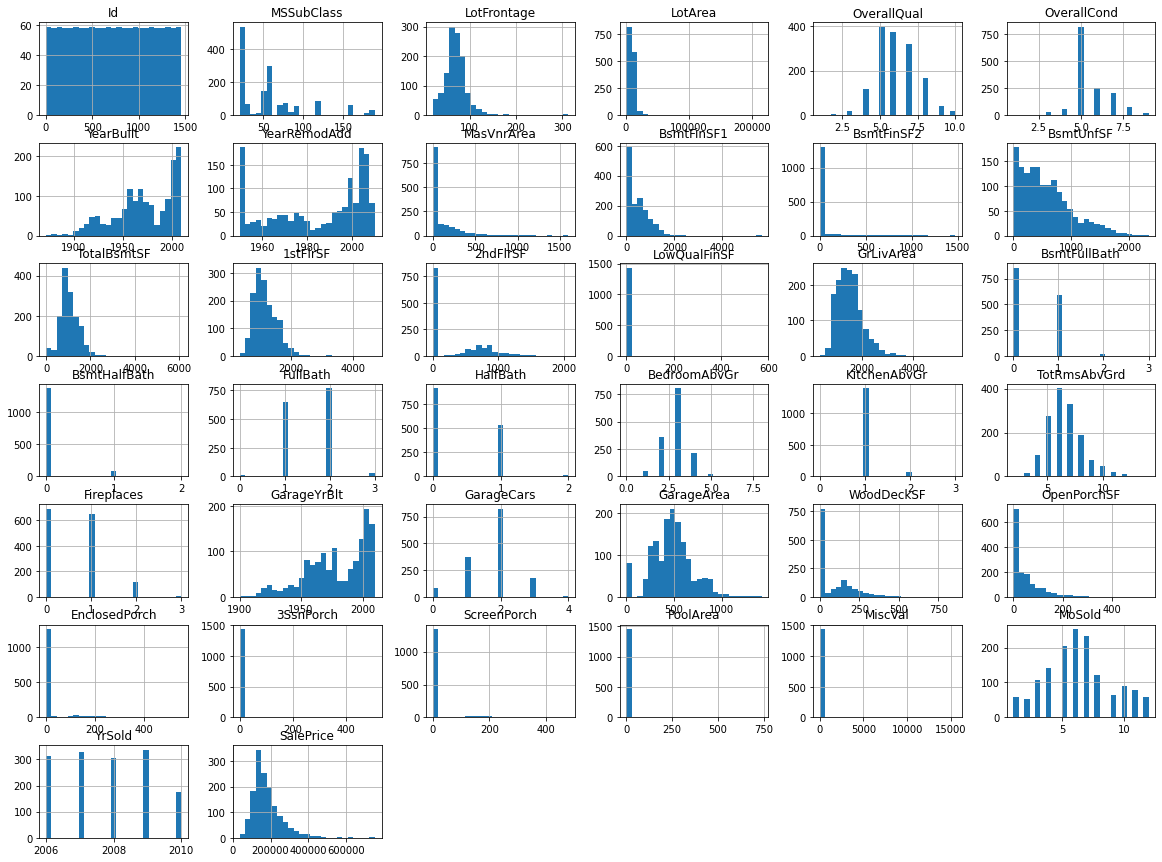

In [3]:
#quickly visualize the training data-histograms
df_train.hist(bins=25, figsize=(20,15))

Notice:

- YearBuilt and YearRemodAdd seem to be linearly-correlated (need we include both? come back to this)
- Is it necessary to keep both 1stFlrSF and GrLivArea?- no just keep GrLivArea
- Is it necessary to keep both BedroomAbvGr, KitchenAbvGr and TotRmsAbvGrd?- no just keep TotRmsAbvGrd
- " WoodDeckSF, OpenPorchSF, EnclosedPorchSF, 3SsnProch, adn ScreenPorch?- just keep the sum of the OpenPorchSF+EnclosedPorchSF
- PoolArea all seems to have 0 as the only entry, is this true for test set too? If so therefore non-informative therefore delete feature- investigate more, keep in data set for now

In [4]:
#consider a scatter matrix here to investigate possible correlation between features

Drop:

-Alley: only 91/1460 non-null entries, not enough information to interpolate accurately.

-MiscFeature: the value of the miscellaneous feature is what is important, not necessarily what the feature is; also isufficient non-null entries (54/1460)

-PoolQC: insufficient non-null entries (7/1460)

-PoolArea: insufficient positive instances (similar case to PoolQC)

-Fence: insufficient non-null entries (281/1460)

-Id: non-predictive

-1stFlrSF, 2ndFlrSF : keeping GrLivArea as it contains information stored in these two variables.


One-Hot Encode: 

-All categorical features

In [5]:
#drop the non-predictive or redudant features
toBeDropped=["Alley","MiscFeature", "Fence","PoolQC", "Id", "PoolArea", "1stFlrSF","2ndFlrSF", "BedroomAbvGr",'KitchenAbvGr', "WoodDeckSF","ScreenPorch", "3SsnPorch"]

The features with null values:

MasVnrArea (8), BsmtQual (37), BsmtCond (37), BsmtExposure (38), BsmtFinType1 (37), BsmtFinType2 (38), Electrical (1), FireplaceQu (770), GarageType (91), GarageYrBuilt (91), GarageFinish (91), GarageQual (91), GarageCond (91)

-either delete the instances with null entries or replace with reasonable values
( numerical values can be interpolated using median statistic, is it reasonable to use the "top" entry for filling in null instances in null-data?)




In [6]:
#since MasVnrArea, GarageYrBlt are numerical, replace null values with an appropriate value

# MasVnrArea, GarageYrBlt null values should just be replaced with zeros (either there are no Masonry Veneers or there is no Garage)

# df_train["MasVnrArea"].fillna(value=df_train["MasVnrArea"].median(), inplace=True)
# df_train["GarageYrBlt"].fillna(value=df_train["GarageYrBlt"].median(), inplace=True)

df_train["MasVnrArea"].fillna(0, inplace=True)
df_train["GarageYrBlt"].fillna(0, inplace=True)

In [7]:
cat=df_train[["Electrical", 'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond']].describe()
cat

,Electrical,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,FireplaceQu,GarageType,GarageFinish,GarageQual,GarageCond
count,1459,1423,1423,1422,1423,1422,770,1379,1379,1379,1379
unique,5,4,4,4,6,6,5,6,3,5,5
top,SBrkr,TA,TA,No,Unf,Unf,Gd,Attchd,Unf,TA,TA
freq,1334,649,1311,953,430,1256,380,870,605,1311,1326


In [8]:
####THIS IS WHAT WE SHOULD DO:
# null instances are NOT missing values in this data set for categorical values
#instead of "Nan" in the entry, change to another string pandas will not recognize as "null"- "empty" perhaps

for feature in cat.columns:
    df_train[feature].fillna("empty", inplace=True) #filling each Nan entry with "empty" so pandas doesnt set to null (all data is valid for these sets)
df_train.info() # checking that it actually worked


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [9]:
df_train=df_train.drop(toBeDropped, axis=1)
# df_train=pd.get_dummies(df_train,columns=toBeDummied, drop_first=True)



In [10]:
#dummy variables after dropping others 
#identify all the categorical features
toBeDummied=[]
for i in range(df_train.shape[1]):
    if df_train.iloc[:,i].dtype==object:
        toBeDummied.append(df_train.columns[i])

In [11]:
print(toBeDummied)

['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']


In [12]:
print(df_train.shape)

(1460, 68)


In [13]:
#now dummy the appropriate variables
df_train=pd.get_dummies(df_train, columns=toBeDummied, drop_first=True)

In [14]:
print(df_train.shape)

(1460, 240)


In [15]:
# check out the data now that all features should be numerical
df_train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,46.549315,...,0.003425,0.003425,0.083562,0.002055,0.867808,0.002740,0.008219,0.013699,0.820548,0.085616
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,161.319273,...,0.058440,0.058440,0.276824,0.045299,0.338815,0.052289,0.090317,0.116277,0.383862,0.279893
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [16]:
#now that data has been appropriately cleaned split the training set into the feature matrix and target variables
X_train=df_train.drop("SalePrice",axis=1)
y_train=df_train["SalePrice"]

## Z-scale the data to ensure no features dominate the predictions

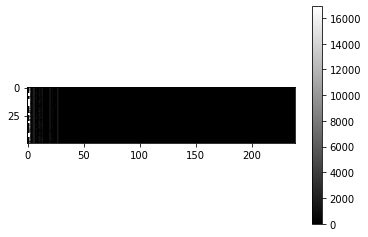

In [17]:
#visualize the first 50 houses as a color map to see the differences
first50=X_train.head(50)
plt.imshow(first50,cmap='gray')
plt.colorbar()
plt.show()

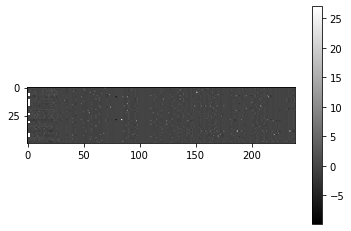

In [18]:
# we should standardize as many of the observations are encoded (0 or 1) and a few which were not are very large relatively speaking 
scaler=StandardScaler(with_mean=True, with_std=True)


#we only wish to scale the predictive features and not the target variable at this point (I think?)
X_train_z_scaled=scaler.fit_transform(X_train)

#now check out the values to see that it worked
first50=X_train_z_scaled[0:50,:]
plt.imshow(first50, cmap='gray')
plt.colorbar()
plt.show()

In [19]:
#this is looking much better! Let us begin model selection and deployment

# Select and Train a Model

Start by defining a loss function: mean squared error

In [20]:
def mse(y,ypred):
    return np.mean((ypred-y)**2)


## Bagging 


In [21]:
# in this algorithm, we tune the number of estimators to explore using the OOB score
#
# once the optimal number of estimators is determined, train and test the algorithm using this architecture

In [ ]:
from sklearn.ensemble import BaggingRegressor


BagReg=BaggingRegressor(oob_score=True, random_state=0)

## Random Forest

In [30]:
# in this algorithm, similarly to bagging regression, we tune the number of trees in the forest using the OOB score

# once the optimal number of estimators is determined, train and test the algorithm using this architecture


In [22]:
# we are iterating over/ tuning the number of trees

from sklearn.ensemble import RandomForestRegressor
from collections import OrderedDict

ensemble_clf=[('Random Forest Regressor OOB Error', RandomForestRegressor(oob_score=True, random_state=0))]

error_rate=OrderedDict((label,  []) for label, _ in ensemble_clf)

#specify the range of trees we wish to explore
min_trees=5
max_trees=10

for label, clf in ensemble_clf:
    for i in range(min_trees, max_trees+1):
        clf.set_params(n_estimators=i) #set the number of trees for each forest
        clf.fit(X_train_z_scaled,y_train)
        
        #make sure to record the OOB score for each forest
        oob_error=1-clf.oob_score_
        error_rate[label].append((i,oob_error))
        
#now create a plot to visualize the OOB error as a function of the size of the forest
for label, clf_err in error_rate.items():
    xs, ys=zip(*clf_err)
    plt.plot(xs,ys, label=label)
    
plt.plot(xlim(min_trees, max_trees))
plt.xlabel("number of trees")
plt.ylabel("OOB error")
plt.legend(loc='upper right')
plt.title("OOB error vs Forest Size")
plt.show()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [28]:
np.where(np.isnan(X_train_z_scaled))

(array([   7,   12,   14,   16,   24,   31,   42,   43,   50,   64,   66,
          76,   84,   95,  100,  104,  111,  113,  116,  120,  126,  131,
         133,  136,  147,  149,  152,  153,  160,  166,  169,  170,  177,
         180,  186,  191,  203,  207,  208,  214,  218,  221,  234,  237,
         244,  249,  269,  287,  288,  293,  307,  308,  310,  319,  328,
         330,  335,  342,  346,  347,  351,  356,  360,  361,  364,  366,
         369,  370,  375,  384,  392,  393,  404,  405,  412,  421,  426,
         447,  452,  457,  458,  459,  465,  470,  484,  490,  496,  516,
         518,  529,  537,  538,  539,  541,  545,  559,  560,  564,  569,
         580,  593,  610,  611,  612,  616,  623,  626,  641,  645,  660,
         666,  668,  672,  679,  682,  685,  687,  690,  706,  709,  714,
         720,  721,  726,  734,  745,  746,  751,  757,  770,  783,  785,
         789,  791,  794,  811,  816,  817,  822,  828,  840,  845,  851,
         853,  855,  856,  859,  865, 

In [29]:
#looks like the problem is coming from the second colum-deal with this later


## XGBoosted Model

In [34]:
# this algorithm is much more sensitive to parameter changes, we will be tuning the learning rate, the tree depth, and the number of trees in the model

# to do this, we will perform a grid search and use cross validation to select the optimal model architecture (we create a validation set using a subset of the training data)


In [33]:
#define the XGB model
from xgboost import XGBRegressor
num_trees=[]
depths=[]
learn_rates=[]
XGB_model=XGBRegressor(max_depth=depths, n_estimators=num_trees,learning_rate=learn_rates, random_state=0)

#define the parameter grid
param_grad=dict({'n_estimators':num_trees,"max_depth":depths,'learning_rate':learn_rates})

In [37]:
#create the validation set
X_train_scaled, X_val,y_train_scaled, y_val=train_test_split(X_train_z_scaled, y_train, test_size=0.3)

In [ ]:
#train the grid search- going to use 3-fold cross-validation
#we can set refit=True meaning that it will re-fit the model at the end using the parameters with best cross-validation score
GridXGB=GridSearchCV(XGB_model, param_grid, cv=3, scoring='mean_squared_error', refit=False)
GridXGB.fit(X_val, y_val)

In [ ]:
#now train on the whole training set using the best model found from the grid search
#show the best parameters found
print(GridXGB.best_params_)

XGB_model_best=XGBRegressor(max_depth=GridXGB.best_params_.get('max_depth'), n_estimators=GridXGB.best_params_.get('n_estimators'), learning_rate=GridXGB.best_params_.get('learning_rate'), random_state=0)

XGB_model_best.fit(X_train_z_scaled, y_train)